## Import & Setup

Note, you can ignore this error:

```
ISAAC SIM may not to be installed. Please install it to use full GO4R functionality.
```

This message appears because this notebook imports packages from the GO4R extension, but it _does not_ need Isaac Sim.

In [1]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo
%pip install -U kaleido

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ISAAC SIM may not to be installed. Please install it to use full GO4R functionality.



Traceback (most recent call last):
  File "/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/__init__.py", line 10, in <module>
    from .extension import *
  File "/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'


Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.


## !! Put the run ID here !!

In [2]:
ROBOT = "jackal"

if ROBOT == "anymal_c":
    # Latest run of anymal_c
    robot_name = "anymal_c"
    run_date_string = "20250506"
    run_time_string = "184959"
    idxs_of_interest = [
        0,      # PRIOR 
        25159,  # More optimal PE, same sensor pkg
        25137,  # More optimal PE, save ~$1300
    ]
elif ROBOT == "jackal":
    # Latest run of jackal
    robot_name = "jackal"
    run_date_string = "20250509"
    run_time_string = "170628"
    idxs_of_interest = [
        0,      # PRIOR 
        # 4,      # TEST
    ]

run_id = f"{robot_name}_{run_date_string}_{run_time_string}"

## Settings which affect performance, but produce different visuals

In [3]:
plot_entropies = True  # Shows the per-voxel entropy in perception space, heavier compute

## Get the Problem & Solution Data

### Problem from the JSON

In [4]:
results_dir = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/"
json_prolem_path = f"{results_dir}problem_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

### Generated designs from CSV

In [5]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)

#### Add some additional stats to the DT for visualization

In [6]:
new_headers = []

# Add up the different sensor types
for k, so in problem.sensor_options.items():
    if so is None:
        continue
    sensor_option_name = so.name
    new_headers.append(f"Total '{sensor_option_name}'s ({k})")
    df[f"Total '{sensor_option_name}'s ({k})"] = (df[[f"s{i}_type" for i in range(problem.max_n_sensors)]] == k).sum(axis=1)

# Add up the total sensors
df[f"Total Sensors"] = df[new_headers].sum(axis=1)
new_headers.append(f"Total Sensors")

df

,id,Name,Generation,Cost,Perception Entropy,Perception Coverage,s0_type,s0_x,s0_y,s0_z,...,s4_x,s4_y,s4_z,s4_qw,s4_qx,s4_qy,s4_qz,Total 'sick_lms1xx_lidar_frame's (1),Total 'bumblebee_stereo_camera_frame's (2),Total Sensors
0,0,Design 0,0,3750.0,5.325692,0.788744,1,0.12,0.0,0.333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2


## Sensor Options

Introspect each sensor's ability to contribute to perception! This is sensitive to the sensor's AP constants.

Sensor: sick_lms1xx_lidar_frame
  FOV: 360.0x30.0
  Resolution: 900x8
  Rays: 7200
  AP Constants: a=0.07999999821186066, b=0.33000001311302185


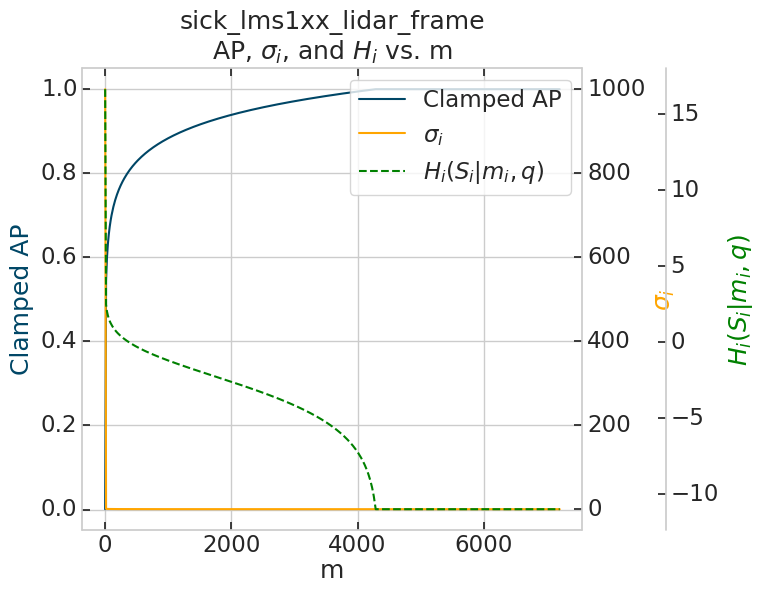

Sensor: bumblebee_stereo_camera_frame
  FOV: 47.16855386689744x35.33942337188053
  Resolution: 721x987
  Rays: 1423254
  AP Constants: a=0.055, b=0.155


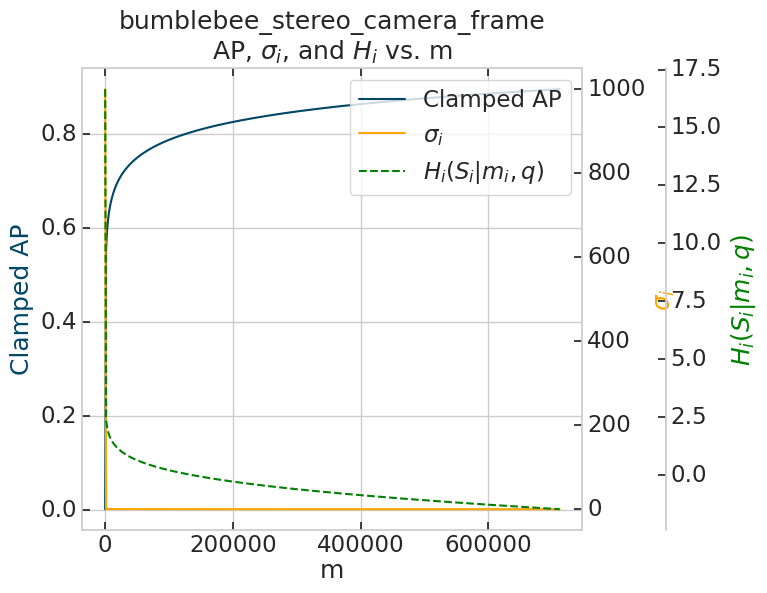

In [7]:
for sensor_option in problem.sensor_options.values():
    if sensor_option is None:
        continue
    sensor_option.plot_ap_h_u_m()

### AP constant parameter sweep

In [8]:
from plotly.subplots import make_subplots
import io, base64
from PIL import Image

def ap_param_sweep(problem,
                   a_vals=np.linspace(0.05, 0.2, 6), 
                   b_vals=np.linspace(-.3, 0.70, 20),
                   subfig_width = 150
    ):
    
    # Make a copy of the first sensor option (lidar) so that we can do a parameter sweep of a and b
    sensor_option = copy.deepcopy(problem.sensor_options[1])

    # Create a 20×20 subplot figure
    fig = make_subplots(
        rows=len(a_vals), cols=len(b_vals),
        horizontal_spacing=0.005, vertical_spacing=0.005,
        subplot_titles=[f"a={a:.2f}, b={b:.2f}" for a in a_vals for b in b_vals]
    )

    # Fill each subplot
    import matplotlib.pyplot as plt

    for i, a in enumerate(a_vals, start=1):
        for j, b in enumerate(b_vals, start=1):
            # update constants and get matplotlib fig
            sensor_option.ap_constants = {"a": a, "b": b}
            sub_fig = sensor_option.plot_ap_h_u_m(show=False, verbose=False)
            
            # render to PNG in memory
            buf = io.BytesIO()
            sub_fig.savefig(buf, format="png", bbox_inches="tight")
            buf.seek(0)
            img_b64 = base64.b64encode(buf.read()).decode()
            plt.close(sub_fig)
            
            # compute normalized subplot position
            x0 = (j-1) / len(b_vals)
            y0 = 1 - (i-1) / len(a_vals)
            sizex = 1 / len(b_vals)
            sizey = 1 / len(a_vals)
            
            # add as a layout image
            fig.add_layout_image({
                "source": f"data:image/png;base64,{img_b64}",
                "xref": "paper", "yref": "paper",
                "x": x0, "y": y0,
                "sizex": sizex, "sizey": sizey,
                "xanchor": "left", "yanchor": "top",
                "layer": "below"
            })

    # Final layout tweaks
    fig.update_layout(
        width=subfig_width*len(b_vals), height=subfig_width*len(a_vals),
        margin=dict(t=50, b=0, l=0, r=0),
        showlegend=False
    )

    fig.show()


In [9]:
# ap_param_sweep(problem,
#                a_vals=np.linspace(0.05, 0.2, 6), 
#                b_vals=np.linspace(-.3, 0.70, 20),
#                subfig_width = 150
#     )

# sensor_option.ap_constants = {"a": 0.08, "b": 0.33}
# sub_fig = sensor_option.plot_ap_h_u_m(show=True, verbose=True)

## NSGA-II Convergence

Plot the hypervolume convergence over time. This can be helpful to plot halfway through to see if the algorithm thinks it is converging.

Note: If you don't provide a reference point, it will use the extents of ALL the generated designs (opposite of the utopia point), so the Hypervolume result may be different if the algorithm finds less optimal designs.

In [10]:
hv_plot, ref_point = plot_hypervolume_over_time(df)
hv_plot

In [11]:
ref_point

(3750.0, 5.325691801594047)

In [12]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"CONVERGENCE_{run_id}.png")
hv_plot.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/CONVERGENCE_jackal_20250509_170628.png


## Objective Trade Space

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

Note: These can take a very long time to generate, especially if you have thousands or tens-of-thousands of designs!!

### Perception Entropy vs Cost

In [13]:
obj_trade_fig = plot_tradespace(df)
obj_trade_fig

In [14]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"TRADESPACE_{run_id}.png")
obj_trade_fig.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/TRADESPACE_jackal_20250509_170628.png


### Perception Coverage vs Cost

In [15]:
obj2_trade_fig = plot_tradespace(
    df, 
    x=("Total Sensors", "sensors"), 
    x_minimize=True,
    y=("Perception Coverage", "fraction"),
    y_minimize=False,
)
obj2_trade_fig

In [16]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"TRADESPACE_2_{run_id}.png")
obj2_trade_fig.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/TRADESPACE_2_jackal_20250509_170628.png


## Pair Plots

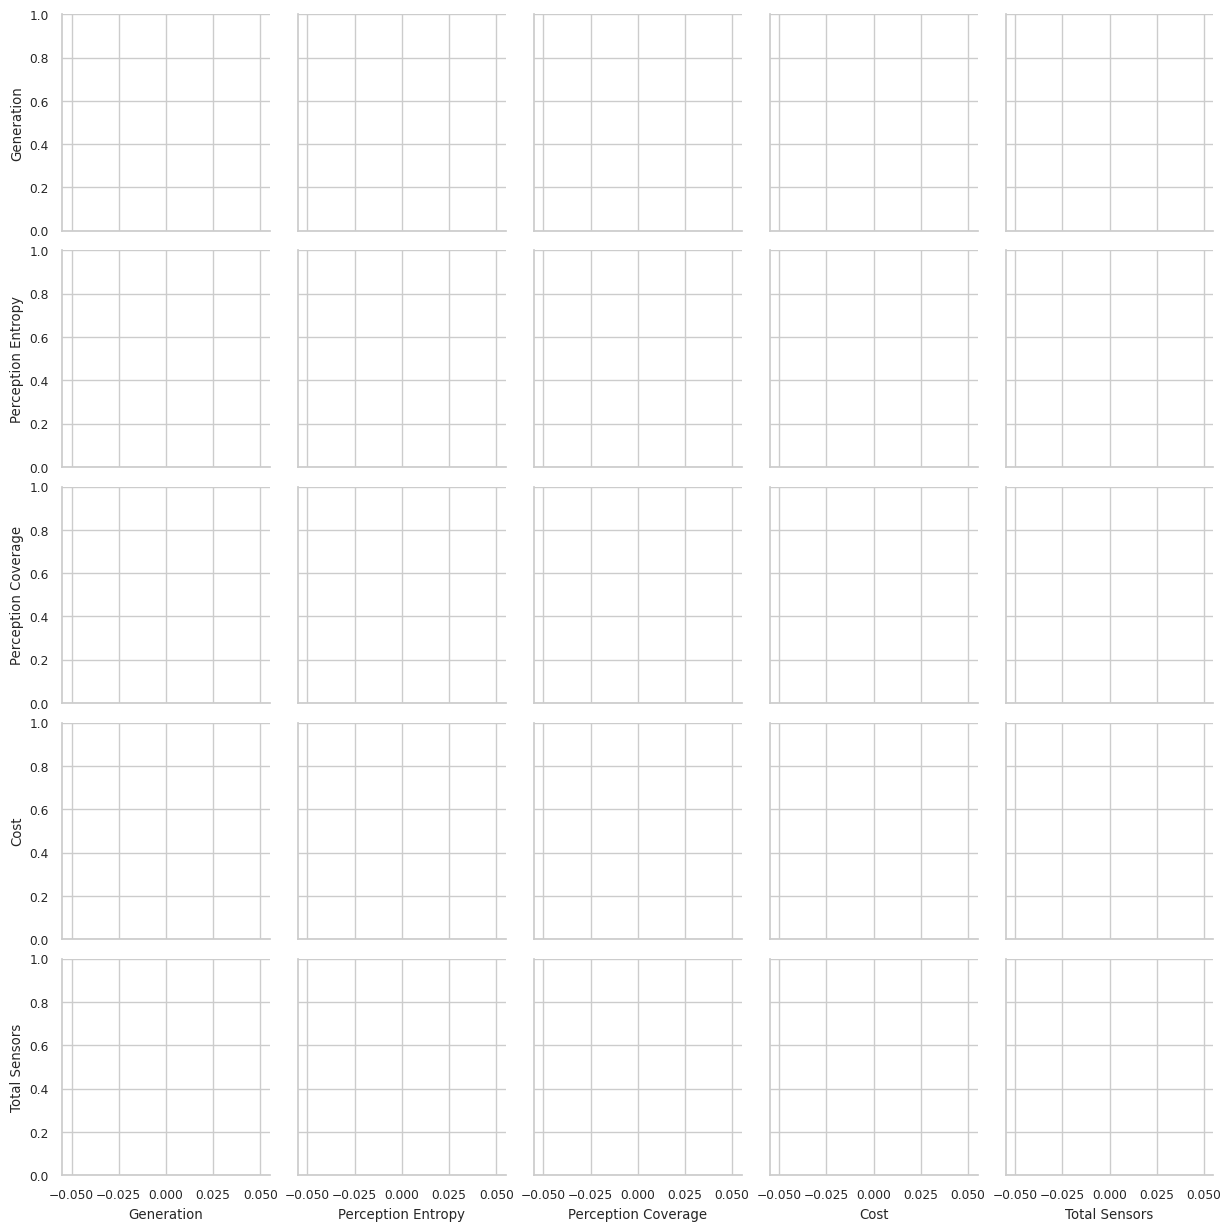

In [17]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=.8)
sns_blues = sns.color_palette(color_scale_blue)
sns.set_palette(sns_blues)

pair_plot_df = df[["Generation", "Perception Entropy", "Perception Coverage", "Cost", "Total Sensors"]].copy()

# Drop "Design 0" because it is the prior design
pair_plot_df = pair_plot_df[pair_plot_df["Generation"] != 0]

n_gens = pair_plot_df["Generation"].nunique()
if n_gens > 5:
    bins = 5
else:
    bins = n_gens

if bins > 2: # There were not enough generations to fill the first 2 bins
    # Bin generations groups and label each bin "X-Y"
    gen_cat = pd.cut(pair_plot_df["Generation"], bins=bins, include_lowest=True)
    bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in gen_cat.cat.categories]
    pair_plot_df["Gen"] = gen_cat.cat.rename_categories(bin_labels)
    pair_plot_df.drop(columns=["Generation"], inplace=True)

    pair_plot_fig = sns.pairplot(
        pair_plot_df,
        hue="Gen",
        diag_kind="kde",
        palette=sns_blues
        )
else:
    pair_plot_fig = sns.pairplot(
        pair_plot_df,
        diag_kind="kde"
        )


In [18]:
# Save the pair plot figure as a PNG
output_path = os.path.join(results_dir, f"PAIR_PLOT_{run_id}.png")
pair_plot_fig.savefig(output_path, dpi=400)
print(f"Saved pair plot to {output_path}")

Saved pair plot to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/PAIR_PLOT_jackal_20250509_170628.png


## Plot any bot from the df above

### Helper fns and data

In [ ]:
from scipy.stats import gaussian_kde

sensor_constraints_mesh_data = box_mesh_data(
    problem.s_bounds,
    opacity=0.25,
    color='blue',
    name='Sensor Pose Constraints',
    legendgroup="Sensor Pose Constraints",
    showlegend=True,
    hoverinfo='skip'
)

def plot_bot_design(design_idx, sensor_idx_rays=None, max_rays=100, ray_length=1.0, colors='weights'):

    rays_per_chunk=8000
    voxels_per_chunk=800

    design_x_df = df[df["id"] == design_idx]
    design_x_dict = design_x_df.iloc[0].to_dict()
    bot_x = problem.convert_1D_to_bot(design_x_dict)
    design_x_fig, design_x_Hs = bot_x.plot_bot_3d(
        perception_space=problem.perception_space,
        perception_space_colors=colors,
        show=False,
        show_sensor_pose_constraints=False,
        max_rays=max_rays,
        ray_length=ray_length,
        show_sensor_rays=sensor_idx_rays,
        width=800,
        rays_per_chunk=rays_per_chunk,
        voxels_per_chunk=voxels_per_chunk,
    )
    design_x_fig.add_trace(sensor_constraints_mesh_data)
    
    design_x_fig.update_layout(
        title=f"Design {design_idx}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data",
        ),
        margin=dict(l=0, r=0, b=0, t=30),
    )

    design_x_fig.show()

    return design_x_fig, design_x_df, design_x_Hs

### Plot The Bots!

At least the ones of interest.

Plot the entropy delpending on the flag set at the beginning of this notebook.

In [28]:
all_design_Hs = []
all_design_x_figs = []
all_design_x_dfs = []
for idx in idxs_of_interest:
    if not plot_entropies:
        design_x_fig, design_x_df, _ = plot_bot_design(idx, sensor_idx_rays=0, max_rays=100)
    else:
        design_x_fig, design_x_df, design_x_Hs = plot_bot_design(
            idx, 
            sensor_idx_rays=True, 
            max_rays=100, 
            colors='entropy')
        all_design_Hs.append(design_x_Hs)
        compare_entropy_histograms(
            design_idxs=[idx],
            entropies=[design_x_Hs],
        )
    
    all_design_x_figs.append(design_x_fig)
    all_design_x_dfs.append(design_x_df)

if plot_entropies:
    compare_entropy_histograms(
            design_idxs=idxs_of_interest,
            entropies=all_design_Hs,
        )

rays_per_chunk: (8000,), voxels_per_chunk: (800,)
rays_per_chunk: (8000,), voxels_per_chunk: (800,)


TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
# Plot a histogram of the entropy values if available
if plot_entropies:
    compare_entropy_histograms(
        design_idxs=[0],
        entropies=all_design_Hs,
    )

Max Entropy: 15.653388023376465
design_0_Hs: [14.961069   1.8425717  1.8398781 ...  1.9341078  1.9332054  1.9666743]
Type: <class 'numpy.ndarray'>, Length: 18693


In [ ]:
INDEX_TO_PLOT = 91 # Approx same cost, better PE
SENSORS = 2
if not plot_entropies:
    design_x_fig, design_x_df, _ = plot_bot_design(INDEX_TO_PLOT, sensor_idx_rays=SENSORS, max_rays=100)

else:
    design_x_fig, design_x_df, design_x_Hs = plot_bot_design(INDEX_TO_PLOT, sensor_idx_rays=SENSORS, max_rays=100, colors='entropy')
    design_0_Hs = all_design_Hs[0]
    compare_entropy_histograms(
            design_idxs=[0, INDEX_TO_PLOT],
            entropies=[design_0_Hs, design_x_Hs],
            bin_size=0.5,
        )

IndexError: single positional indexer is out-of-bounds

## Random Testing

### Ray/Voxel Traversal (measurement) test case

In [ ]:
ro = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
rd = torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[np.sqrt(0.5), np.sqrt(0.5), 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['','','','',''],
                                                voxel_centers=torch.tensor([
                                                    #  X     Y     Z
                                                    [-0.5, -0.5,  0.0],  # Behind the sensor, should have 0 hits
                                                    [ 0.0,  0.0,  0.0],    # At center of sensor, should have 3 hits
                                                    [ 0.5,  0.0,  0.0],      # Along x-axis, should have 1 hit
                                                    [ 1.0,  0.5,  0.0],     # Should have 0 hits
                                                    [ 0.0,  1.0,  0.0],    # Should have 0 hits if occluded, 1 if not
                                                    ]),
                                                voxel_sizes=torch.tensor([0.1,0.1,0.1,0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

simple_sensor:Sensor3D_Instance = Sensor3D_Instance(
    sensor=Sensor3D(
        name="simple_sensor",
    ),
    path='',
    tf=((0, 0, 0), (1, 0, 0, 0)),
    name="simple_sensor_instance",
)

body_aabb_extents = [
    [(-0.1,  0.1), ( 0.4,  0.6), (-0.1,  0.1)], # This one only occludes the voxel at (0,1,0)
    # [(-0.1,  0.1), (-0.1,  0.1), (-0.1,  0.1)], # This one occludes everythin because sensor is at (0,0,0)
    ]
body_mesh_data = []
for i, aabb in enumerate(body_aabb_extents):
    
    body_mesh_data.append(
        box_mesh_data(
            extents=body_aabb_extents[i], 
            color="red", 
            opacity=0.2, 
            name=f"Occluder {i}"
        )
    )

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
simple_sensor.plot_rays(ro, rd, show=False, max_rays=5, fig=one_ray_fig, ray_length=1.25)
for i, aabb in enumerate(body_aabb_extents):
    one_ray_fig.add_trace(body_mesh_data[i])


one_ray_fig

AttributeError: 'tuple' object has no attribute 'add_trace'

In [ ]:
simple_perception_space.chunk_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.01 seconds for 3 rays and 5 voxels.
  VOXEL HITS max: 3, min: 0


tensor([0, 3, 1, 0, 1], device='cuda:0')

In [ ]:
simple_perception_space.chunk_occluded_ray_voxel_intersections(ro, rd, body_aabbs=body_aabb_extents, verbose=True)

Done in 0.00s for 3 rays × 5 voxels; hits max=3, min=0


tensor([0, 3, 1, 0, 0], device='cuda:0')